## Import libraries

# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams
This is the code for the paper entitled "**A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams**" accepted in IEEE Internet of Things Magazine.  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 2: Static machine learning algorithms**  
Aims:  
&nbsp; 1): Find the best performing static machine learning algorithm by considering both accuracy and time  
&nbsp; 2): Obtain the optimized learner using hyperparameter optimization techniques  
目的：
1） ：通过考虑准确性和时间，找到性能最佳的静态机器学习算法
2） ：使用超参数优化技术获得优化的学习器

In [2]:
!pip install dask[dataframe]#Dask的DataFrame查询计划功能被禁用了，因为dask-expr没有安装

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings("ignore")#用于控制警告信息显示的函数;告诉Python解释器忽略所有发出的警告信息

## Read the NSL-KDD dataset

In [5]:
#Read the training and test set
df1 = pd.read_csv("NSL_KDD_binary_train.csv")
df2 = pd.read_csv("NSL_KDD_binary_test.csv")

In [6]:
X_train = df1.iloc[:, :-1].values #所有行,但不选最后一列的df数据 作为特征
y_train = df1.iloc[:, -1].values  #所有行,且只选最后一列的df数据  作为标签
X_test = df2.iloc[:, :-1].values
y_test = df2.iloc[:, -1].values

In [7]:
df2

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,45,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
1,0,1,45,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
2,2,1,19,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0
3,0,0,13,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,1
4,1,1,55,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
22540,0,1,22,9,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
22542,0,2,11,9,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


## Training 5 static machine learning algorithms:
##训练5种静态机器学习算法:
### KNN, LR, RF, XGBoost, LightGBM


Precision（精确度）：精确度是指在所有被预测为正类的样本中,实际为正类的比例.

Recall（召回率）:召回率是指在所有实际为正类的样本中,被正确预测为正类的比例.

F1-score（F1分数）:是精确度和召回率的调和平均数，它试图在精确度和召回率之间找到一个平衡.F1分数越高，模型的性能越好.

Support（支持度）:是指每个类别的实际出现次数.

Accuracy（准确率）:准确率是指所有预测中正确预测的比例.
macro-avg和weighted-avg主要用于评估多分类模型性能,处理不平衡数据特别有用.

Macro avg（宏平均）:宏平均是对每个类别的指标（如精确度、召回率、F1分数）进行平均，不考虑类别的支持度（样本数量）.

Weighted avg（加权平均）: 加权平均是对每个类别的指标进行平均,但是会根据每个类别的支持度（样本数量）进行加权.

              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.96      0.62      0.76     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.83      0.77      0.77     22544

Accuracy: 0.7720457771469127


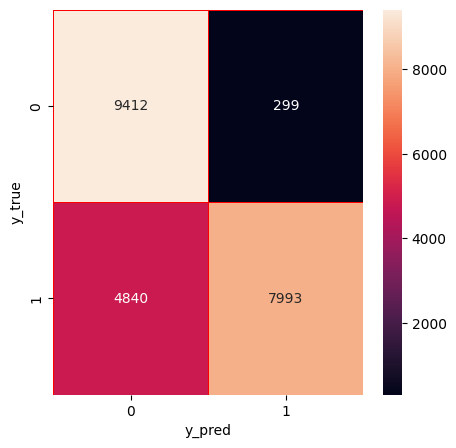

CPU times: user 24.9 s, sys: 129 ms, total: 25 s
Wall time: 25.9 s


In [8]:
#%%time是一个魔法命令,它用来测量和打印一个代码块的执行时间.当你在代码单元的开头使用%%time,Jupyter会记录下该代码块开始和结束时的时间，并在代码执行完毕后打印出总的执行时间
%%time
# Print out execution time

# KNN algorithm KNN算法
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier() # 实例化
classifier.fit(X_train, y_train) # Model training 参数分别是数据集的特征和标签
y_pred = classifier.predict(X_test) # Model testing 利用测试集对训练好的模型进行预测
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix 混淆矩阵
cm=confusion_matrix(y_test,y_pred)  #使用confusion_matrix函数,传入真实的标签y_test和模型预测的标签y_pred,计算混淆矩阵.这个函数返回一个矩阵,其中行表示实际类别,列表示预测类别
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)  #绘制热力图
# cm：混淆矩阵。
# annot=True：在热力图的每个单元格中标注数值。
# linewidth=0.5：单元格之间的线宽。
# linecolor="red"：单元格之间的线的颜色。
# fmt=".0f"：标注数值的格式，这里表示保留0位小数的浮点数。
# ax=ax：指定绘制热力图的坐标轴。
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.90      0.72      9711
           1       0.88      0.56      0.68     12833

    accuracy                           0.70     22544
   macro avg       0.74      0.73      0.70     22544
weighted avg       0.76      0.70      0.70     22544

Accuracy: 0.7044889992902768


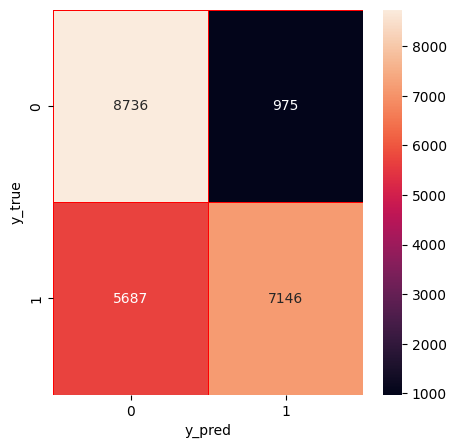

CPU times: user 6.31 s, sys: 2.04 s, total: 8.35 s
Wall time: 5.06 s


In [9]:
%%time
# Logistic regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.76     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.76      0.76     22544

Accuracy: 0.7639283179559971


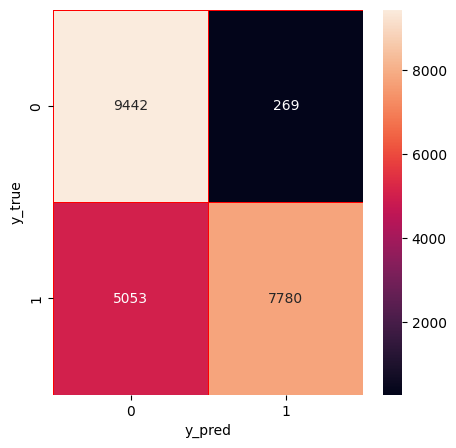

CPU times: user 12.5 s, sys: 103 ms, total: 12.6 s
Wall time: 12.5 s


In [10]:
%%time
# Random forest algorithm
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.69      0.97      0.81      9711
           1       0.97      0.67      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544

Accuracy: 0.8016323633782825


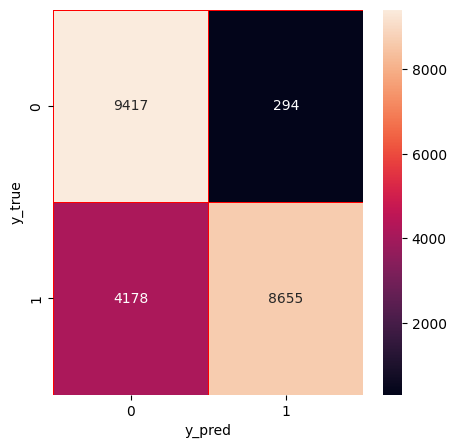

CPU times: user 4.7 s, sys: 131 ms, total: 4.83 s
Wall time: 3.2 s


In [11]:
%%time
# XGBoost algorithm
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[LightGBM] [Info] Number of positive: 58630, number of negative: 67343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3226
[LightGBM] [Info] Number of data points in the train set: 125973, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465417 -> initscore=-0.138552
[LightGBM] [Info] Start training from score -0.138552
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.66      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544

Accuracy: 0.7935149041873669


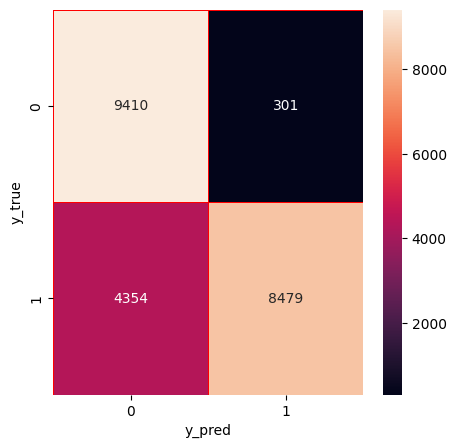

CPU times: user 2.47 s, sys: 129 ms, total: 2.6 s
Wall time: 2.53 s


In [12]:
%%time
# LightGBM algorithm
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Considering both accuracy and execution time, **LightGBM** performs the best among the five algorithms:  
Accuracy: 79.35%, time: 0.6s.  

# Hyperparameter optimization
# 超参数优化
Tune the hyperparameters of LightGBM to obtain optimal accuracy.

#### Optimize LightGBM by Bayesian Optimization with Tree-structured Parzen Estimator (BO-TPE)
#### 基于树结构Parzen估计器（BO-TPE）的贝叶斯优化方法优化

In [13]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials #用hyperopt库来优化LightGBM分类器的超参数
# hp：用于定义超参数空间.
# fmin：用于找到最小化目标函数的超参数值.
# tpe：表示使用树的参数有效性（Tree-structured Parzen Estimator）算法来提出新的超参数值.
# STATUS_OK：表示优化过程中的状态正常.
# Trials：用于存储优化过程中的试验结果.
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    # 将参数字典转换为整数或浮点数，并创建 LightGBM 分类器的参数
    # 五个超参数,通过PSO得到最优值

    params = {
        'n_estimators': int(params['n_estimators']), # 数的分布
        'max_depth': int(params['max_depth']),  # 树的最大深度
        'learning_rate': abs(float(params['learning_rate'])), # 学习率
        "num_leaves": int(params['num_leaves']),  # 叶子节点的数量
        "min_child_samples": int(params['min_child_samples']),  # 子节点的最小样本数
    }
    clf = lgb.LGBMClassifier( **params) # 创建一个 LightGBM 分类器 clf
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)  # 预测
    score = accuracy_score(y_test,prediction) # 计算准确率
    return {'loss':-score, 'status': STATUS_OK } # 返回一个字典，包含负的准确率（因为 fmin 寻找的是最小值，而我们希望最大化准确率）和状态

# Define the hyperparameter configuration space
# 超参数空间space定义了每个超参数的可能取值范围
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 20), # 树的数量，均匀分布，步长为20
    'max_depth': hp.quniform('max_depth', 5, 50, 1), # 树的最大深度，均匀分布，步长为1
    "learning_rate":hp.uniform('learning_rate', 0, 1), # 学习率，均匀分布
    "num_leaves":hp.quniform('num_leaves',100,2000,100), # 叶子节点的数量，均匀分布，步长为100
    "min_child_samples":hp.quniform('min_child_samples',10,50,5), # 子节点的最小样本数，均匀分布，步长为5
}

# Detect the optimal hyperparameter values
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, # 使用 TPE 算法
            max_evals=50)  # 最大评估次数
print("LightGBM: Hyperopt estimated optimum {}".format(best))

流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

作者用hyperopt库跑的超参数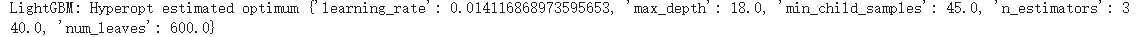Accuracy: 0.8021202980837473

[LightGBM] [Info] Number of positive: 58630, number of negative: 67343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 125973, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465417 -> initscore=-0.138552
[LightGBM] [Info] Start training from score -0.138552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

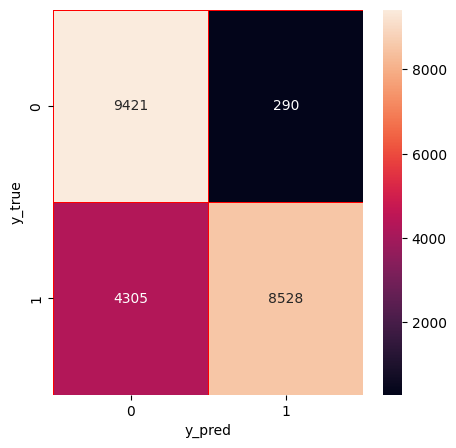

In [16]:
# Use the optimal hyperparameter values to train the optimized LightGBM model
# 得到的hyper-parameter values与文章所用的参数不一致
clf = lgb.LGBMClassifier(max_depth=26, learning_rate= 0.6161192430617404, n_estimators = 340,
                         num_leaves = 1100, min_child_samples = 50)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()
# 文章利用的超参数跑出来的结果是80几%，自己跑的结果是0.796

#### Optimize LightGBM by particle swarm optimization (PSO)

In [18]:
!pip install optunity # optunity 是一个用于机器学习模型超参数优化的库，它提供了多种优化算法，包括粒子群优化（PSO）

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72027 sha256=a9315fe97f14d2a233baf5075aacff9380069c434588ec2af322100635d2c7db
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built optunity


作者用PSO跑的超参数以及ACC值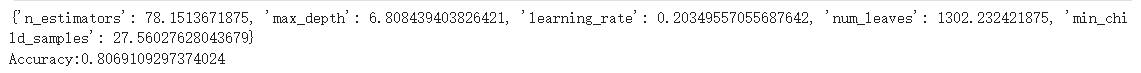

In [19]:
#PSO
# 使用 optunity 库来执行粒子群优化（PSO）算法，以寻找 LightGBM 分类器的最优超参数
import optunity
import optunity.metrics

# Define the hyperparameter configuration space
search = {
    'n_estimators': [50, 500],
    'max_depth': [5, 50],
    'learning_rate': (0, 1),
    "num_leaves":[100, 2000],
    "min_child_samples":[10, 50],
         }
# Define the objective function
def performance(n_estimators=None, max_depth=None,learning_rate=None,num_leaves=None,min_child_samples=None):
    clf = lgb.LGBMClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=float(learning_rate),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        )
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    score = accuracy_score(y_test,prediction)
    return score

# Detect the optimal hyperparameter values
# 使用 optunity.maximize函数来寻找最优的超参数配置; maximize函数尝试最大化目标函数的返回值（即准确率）
optimal_configuration, info, _ = optunity.maximize(performance,solver_name='particle swarm',num_evals=50,**search)
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Info] Number of positive: 58630, number of negative: 67343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 125973, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465417 -> initscore=-0.138552
[LightGBM] [Info] Start training from score -0.138552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

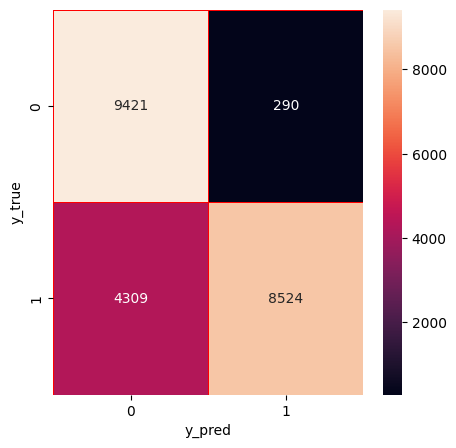

In [20]:
clf = lgb.LGBMClassifier(max_depth=35, learning_rate= 0.21169778417329552, n_estimators = 491,
                         num_leaves = 1960, min_child_samples = 49)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

After hyperparameter optimization, the accuracy of LightGBM can be improved from 79.35% to 80.69%.（author's data）

### Save and load the optimized model

In [21]:
#使用joblib库来序列化（pickle）一个训练好的LightGBM模型,并将其保存到一个名为Optimized_lightGBM.pkl的文件中.用于在Python程序之间共享模型,或者将模型保存到磁盘上以便将来使用,而无需重新训练
import joblib
# Output a pickle file to save the trained model
joblib.dump(clf, 'Optimized_lightGBM.pkl')

['Optimized_lightGBM.pkl']

In [22]:
# The trained model can be loaded directly for future testing
# 使用 joblib 库来加载之前保存的 LightGBM 模型
savestkrf = joblib.load('Optimized_lightGBM.pkl')

In [23]:
y_pred = savestkrf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[9421  290]
 [4309 8524]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.80      9711
           1       0.97      0.66      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.79     22544

0.7959989354151881


However, the accuracy is still at a low level. A model with the accuracy of 80% cannot detect attacks accurately.

## Find the reason why the accuracy is low
## 找出准确率为什么那么低

Read the entire dataset (training+test)

In [25]:
df = pd.read_csv("NSL_KDD_binary(train+test).csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [35]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, random_state = 0,shuffle=False)

[LightGBM] [Info] Number of positive: 6932, number of negative: 7919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 14851, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466770 -> initscore=-0.133117
[LightGBM] [Info] Start training from score -0.133117
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     69135
           1       0.99      0.92      0.96     64531

    accuracy                           0.96    133666
   macro avg       0.96      0.96      0.96    133666
weighted avg       0.96      0.96      0.96    133666

Accuracy: 0.9604237427618093


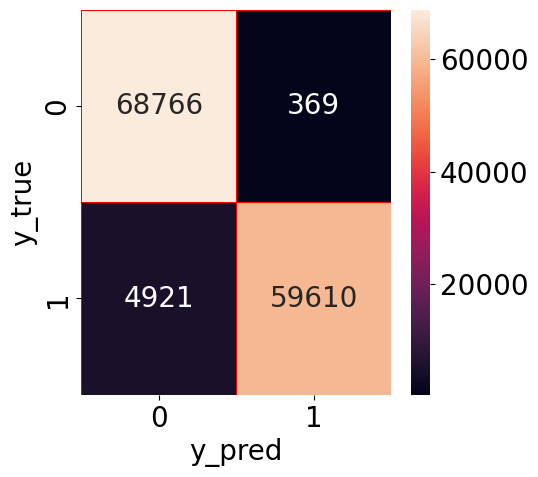

In [36]:
# LightGBM algorithm
# 再次使用LightGBM算法基于重新划分的数据集对数据集进行训练
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Monitor how the accuracy changes over time

In [37]:
# Record the real-time accuracy based on timestamp/sample index
# 实时记录并计算模型在测试集y_test上的准确率，随着每个样本的预测进行更新
acc = []
acc_sum = 0
for i in range(0, len(y_test)):
    if y_test[i] == y_pred[i]: # 检查真实标签和预测标签是否相同
        acc_sum = acc_sum + 1
    accuracy = acc_sum/(i+1)
    acc.append(accuracy)

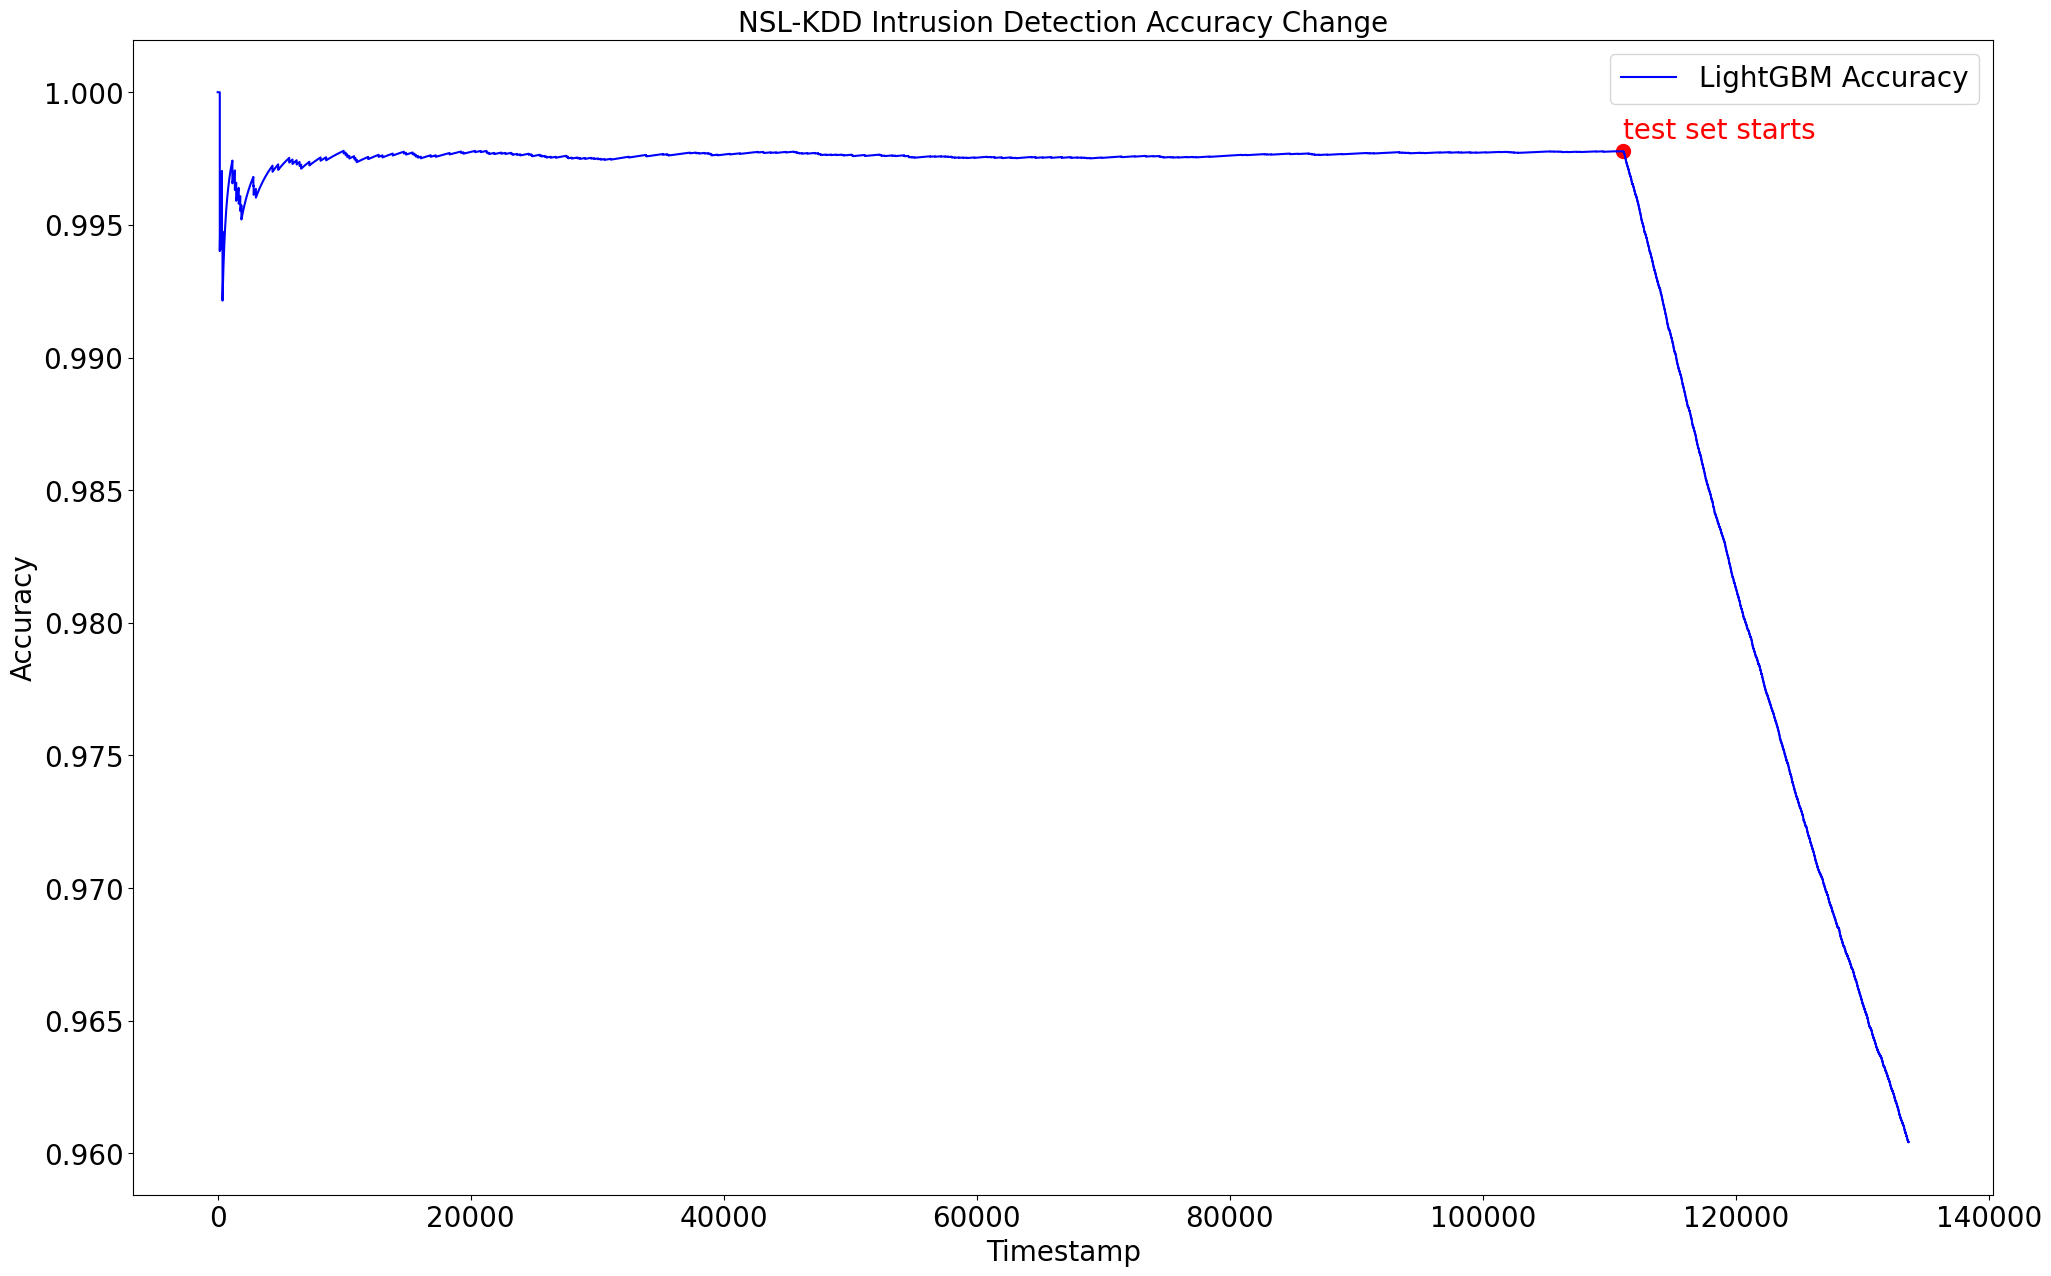

In [38]:
# Plot the accuracy changes
plt.rcParams.update({'font.size': 20}) # 绘图时的默认字体大小为20
plt.figure(1,figsize=(24,15)) # 尺寸为24x15英寸
plt.clf() # 清除当前图形，为新的绘图做准备
plt.plot(acc,'-b',label='LightGBM Accuracy')
# 标记测试集开始的位置
plt.scatter(len(df1)-len(X_train),acc[len(X_test)-len(df2)],s=100,c='r')
plt.text(len(df1)-len(X_train),acc[len(X_test)-len(df2)]+0.0005, 'test set starts', c='r')

plt.legend(loc='best')
plt.title('NSL-KDD Intrusion Detection Accuracy Change', fontsize=20)
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')

plt.draw()

* The samples in the training set have similar statistical distribution. However, when the statistical distribution from the training set to the test set has changed. Hence, the model trained on the training set cannot accurately detect attacks in the test set.   
* In the figure, it can be seen that when the test set starts, the current accuracy starts to drop significantly due to the statistical distribution change in the dataset.  
* This kind of statistical distribution change is called **concept drift**.

##训练集中的样本具有相似的统计分布。然而，当从训练集到测试集的统计分布发生变化时。因此，在训练集上训练的模型无法准确检测测试集中的攻击。

##从图中可以看出，当测试集开始时，由于数据集中的统计分布变化，当前的准确性开始显著下降。

##这种统计分布变化称为**概念漂移**